# This notebook implements Deep learning techniques for a particle-in-halo classification framework. 

Reference with random forest: [ChJazhiel notebook](https://github.com/ChJazhiel/ML_ICF/blob/master/RF_Particles_z23.ipynb)

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pandas as pd

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses

%matplotlib inline

# workdirectory = '/home/jazhiel/ML_Notebooks/Cosmology_ML/'
workdirectory = ''

2022-05-11 15:14:28.848856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/isidro/cfitsio/lib:/home/isidro/MultiNest/lib:/home/isidro/cuba/:LD_LIBRARY_PATH:/home/isidro/.openmpi/lib/:/lib
2022-05-11 15:14:28.848913: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Import our dataset 

In [2]:
data_dict = np.load(workdirectory + 'OUTFILE1M.npz') #np.load('/path/to/nbody/outfile.npz')
test_flags  = data_dict['test_flags'] ## not important
test_hosts  = data_dict['test_hosts'] ### somewhat relevant
test_mass   = data_dict['test_mass'] ## important
test_labels = data_dict['test_labels'] ## important
test_input  = data_dict['test_input'] ## very important
#test_snid   = dict_data['test_snid']
#test_labels = dict_data['test_labels']
print(test_mass) ## Here I want to check how is the halo mass matrix composed of, the -1 means the halo 
#is not in our range of 10^12-10^13 M_sun
print(np.sum(test_labels)) ## Here I want to check how many label "1" do we have

[-1.00000000e+00  2.72242898e+13  1.13894322e+13 ... -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00]
289964


## Data preprocessing

In [3]:
### here we create or 10 vector dataset, I wonder if by adding some other information the classification will be better
### adding mass is not helpful, the classifier is perfect in that regard
dr1 = pd.DataFrame(test_input[0], columns = ['dr1'])
dr2 = pd.DataFrame(test_input[1], columns = ['dr2'])
dr3 = pd.DataFrame(test_input[2], columns = ['dr3'])
dr4 = pd.DataFrame(test_input[3], columns = ['dr4'])
dr5 = pd.DataFrame(test_input[4], columns = ['dr5'])
dr6 = pd.DataFrame(test_input[5], columns = ['dr6'])
dr7 = pd.DataFrame(test_input[6], columns = ['dr7'])
dr8 = pd.DataFrame(test_input[7], columns = ['dr8'])
dr9 = pd.DataFrame(test_input[8], columns = ['dr9'])
dr10 = pd.DataFrame(test_input[9], columns = ['dr10'])
#mass = pd.DataFrame(test_mass, columns = ['Halo_Mass'])
lbl = pd.DataFrame(test_labels, columns =['labels'])

## Select all features and create dataframe

In [4]:
df = pd.concat([dr1, dr2, dr3, dr4, dr5, dr6, dr7, dr8, dr9, dr10, lbl], axis=1, ignore_index=False, sort=False)
df

,dr1,dr2,dr3,dr4,dr5,dr6,dr7,dr8,dr9,dr10,labels
0,-0.209889,-0.187730,-0.169542,-0.155964,-0.100744,-0.049741,-0.011099,-0.010984,-0.002834,0.024089,0
1,0.364046,0.430008,0.453121,0.450021,0.374578,0.309706,0.240559,0.190503,0.174401,0.176335,1
2,0.311775,0.254511,0.227109,0.215286,0.148460,0.112097,0.090454,0.058546,0.035873,0.043613,1
3,0.033877,0.051836,0.065151,0.073930,0.100935,0.100271,0.094132,0.080007,0.059981,0.032160,0
4,-0.355428,-0.330448,-0.306125,-0.291701,-0.253399,-0.215256,-0.163749,-0.124680,-0.080408,-0.051999,0
...,...,...,...,...,...,...,...,...,...,...,...
999995,0.022223,0.034349,0.046298,0.047812,0.027945,0.018082,0.012005,0.015623,0.028762,0.036779,0
999996,-0.178963,-0.188312,-0.189045,-0.187326,-0.182576,-0.170714,-0.155041,-0.143078,-0.136640,-0.120222,0
999997,-0.164632,-0.113120,-0.076089,-0.061724,0.009549,0.039809,0.057906,0.041327,0.010610,-0.020231,0
999998,-0.039698,0.063765,0.118363,0.140928,0.152761,0.125845,0.114529,0.113929,0.107155,0.098008,0


## Here we select a dataframe consisting of evenly separated labels

(I'm not sure if selecting all particles will impact in a different result)


In [5]:
## Sorting out the labels consisting in label '0' and label '1'
## Then we sample them in order to not selecting them in a specific range or shape

df_0 = df.sort_values('labels').head(710036).sample(289000)
df_1 = df.sort_values('labels').tail(289964).sample(289000) 
df_1.labels.sum()
df_r = pd.concat([df_0, df_1])


randomize = np.random.permutation(len(df_r.values))
data = df_r.values[randomize]

## define a size for our traning dataset 

I think that for 500k + particles we can divide into train, test and validation datasets

In [6]:
# Define a size for your train set 
split = 0.8
ntrain = int(split * len(data))
indx = [ntrain]
train_set, test_set = np.split(data, indx)

split = 0.5
ntrain = int(split * len(test_set))
indx = [ntrain]
validation_set, test_test = np.split(test_set, indx)

## Select data, X for attributes, y for labels

In [7]:
X_train = train_set[:, :-1]
y_train = train_set[:, -1]

X_val = validation_set[:, :-1]
y_val = validation_set[:, -1]

X_test = test_set[:, :-1]
y_test = test_set[:, -1]

In [8]:
np.shape(X_train), np.shape(X_val), np.shape(X_test), np.shape(y_train), np.shape(y_val), np.shape(y_test)

((462400, 10), (57800, 10), (115600, 10), (462400,), (57800,), (115600,))

## For the Confusion matrix 


In [9]:
#### THIS CELL IS FOR CALCULATE THE CONFUSION MATRIX ####
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

## Random forest with sklearn 

In [10]:
rf=RandomForestClassifier(n_estimators=100, max_depth=8, n_jobs=-1,
                          criterion = 'entropy', class_weight='balanced')

## n_jobs = -1 tells my computer to use all its cores, I have only 2, so it runs on 2 cores
#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)



RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, n_jobs=-1)

In [28]:
ypred = rf.predict(X_test)
#####
print('Traning and Testing on raw data, all features \n');
#### Model accuracy
print("Accuracy:", metrics.accuracy_score(y_test, ypred))
print("F1:", metrics.f1_score(y_test, ypred.round()))
print("Precision:", metrics.precision_score(y_test, ypred))

X = data[:,:-1]
y = data[:,1]
np.shape(X), np.shape(y)

Traning and Testing on raw data, all features 

Accuracy: 0.7856574394463668
F1: 0.7928676519761921
Precision: 0.7686186161850274


((578000, 10), (578000,))

In [12]:
# for i, score_forest in enumerate(cross_val_score(rf, X, y, cv = 3)):
#     print('Random Forest accuracy for the %d score: %0.2f' % (i, score_forest))
# score_forest=cross_val_score(rf, X, y, cv=3)
# #score_tree
# cv_scores = []
# print("Random Forest Accuracy: %0.2f (+/- %0.2f)" % (score_forest.mean(), score_forest.std() * 2 ))
# cv_score = score_forest.mean()
# cv_scores.append(cv_score)

## Perceptron with Keras

In [43]:
#para scikit-learn: (samples,features)
#test_input_T = test_input.T
#X_train, X_test, y_train, y_test = train_test_split(test_input_T,test_labels,test_size=0.25,random_state=None)

#ANN
test1_model = models.Sequential()
test1_model.add(layers.Dense(200,activation='tanh',input_shape=(10,)))
test1_model.add(layers.Dense(200,activation='tanh'))
test1_model.add(layers.Dense(200,activation='tanh'))
#test1_model.add(layers.Dense(32,activation='relu'))
#test1_model.add(layers.Dense(10,activation='relu'))
test1_model.add(layers.Dense(1, activation='sigmoid'))

test1_model.compile(optimizer=optimizers.Adam(),#RMSprop(lr=0.001),
                    loss=losses.binary_crossentropy,
                    metrics=['accuracy'])


test1_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               1100      
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 21,401
Trainable params: 21,401
Non-trainable params: 0
_________________________________________________________________


In [44]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)]
test1_model_history = test1_model.fit(X_train,
                                      y_train,
                                      epochs=200,
                                      batch_size=512,
                                      validation_data=(X_val,y_val),
                                      verbose=1, callbacks=callbacks)

Epoch 1/200
904/904 [==============================] - 5s 5ms/step - loss: 0.4733 - accuracy: 0.7754 - val_loss: 0.4633 - val_accuracy: 0.7801
Epoch 2/200
904/904 [==============================] - 4s 5ms/step - loss: 0.4614 - accuracy: 0.7813 - val_loss: 0.4611 - val_accuracy: 0.7814
Epoch 3/200
904/904 [==============================] - 3s 3ms/step - loss: 0.4608 - accuracy: 0.7816 - val_loss: 0.4614 - val_accuracy: 0.7818
Epoch 4/200
904/904 [==============================] - 3s 3ms/step - loss: 0.4604 - accuracy: 0.7819 - val_loss: 0.4604 - val_accuracy: 0.7819
Epoch 5/200
904/904 [==============================] - 3s 3ms/step - loss: 0.4601 - accuracy: 0.7819 - val_loss: 0.4605 - val_accuracy: 0.7824
Epoch 6/200
904/904 [==============================] - 3s 3ms/step - loss: 0.4598 - accuracy: 0.7819 - val_loss: 0.4597 - val_accuracy: 0.7816
Epoch 7/200
904/904 [==============================] - 3s 3ms/step - loss: 0.4596 - accuracy: 0.7818 - val_loss: 0.4596 - val_accuracy: 0.7820

Epoch 58/200
904/904 [==============================] - 4s 4ms/step - loss: 0.4543 - accuracy: 0.7841 - val_loss: 0.4562 - val_accuracy: 0.7827
Epoch 59/200
904/904 [==============================] - 3s 3ms/step - loss: 0.4543 - accuracy: 0.7841 - val_loss: 0.4550 - val_accuracy: 0.7837
Epoch 60/200
904/904 [==============================] - 2s 3ms/step - loss: 0.4542 - accuracy: 0.7842 - val_loss: 0.4551 - val_accuracy: 0.7835
Epoch 61/200
904/904 [==============================] - 3s 3ms/step - loss: 0.4542 - accuracy: 0.7842 - val_loss: 0.4551 - val_accuracy: 0.7839
Epoch 62/200
904/904 [==============================] - 3s 3ms/step - loss: 0.4540 - accuracy: 0.7844 - val_loss: 0.4551 - val_accuracy: 0.7842
Epoch 63/200
904/904 [==============================] - 3s 4ms/step - loss: 0.4541 - accuracy: 0.7846 - val_loss: 0.4548 - val_accuracy: 0.7838
Epoch 64/200
904/904 [==============================] - 4s 4ms/step - loss: 0.4539 - accuracy: 0.7842 - val_loss: 0.4547 - val_accuracy:

Epoch 115/200
904/904 [==============================] - 4s 4ms/step - loss: 0.4497 - accuracy: 0.7867 - val_loss: 0.4525 - val_accuracy: 0.7861
Epoch 116/200
904/904 [==============================] - 4s 4ms/step - loss: 0.4496 - accuracy: 0.7866 - val_loss: 0.4538 - val_accuracy: 0.7837
Epoch 117/200
904/904 [==============================] - 3s 4ms/step - loss: 0.4494 - accuracy: 0.7864 - val_loss: 0.4525 - val_accuracy: 0.7856
Epoch 118/200
904/904 [==============================] - 3s 3ms/step - loss: 0.4494 - accuracy: 0.7867 - val_loss: 0.4523 - val_accuracy: 0.7858
Epoch 119/200
904/904 [==============================] - 3s 4ms/step - loss: 0.4491 - accuracy: 0.7868 - val_loss: 0.4525 - val_accuracy: 0.7856
Epoch 120/200
904/904 [==============================] - 4s 4ms/step - loss: 0.4491 - accuracy: 0.7868 - val_loss: 0.4525 - val_accuracy: 0.7849
Epoch 121/200
904/904 [==============================] - 4s 4ms/step - loss: 0.4491 - accuracy: 0.7867 - val_loss: 0.4528 - val_ac

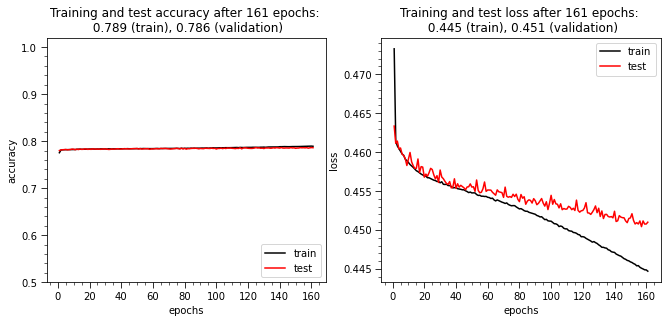

In [45]:
#plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,4.5))    

results_dict = test1_model_history.history
epochs = range(1,len(results_dict['accuracy'])+1)

#accuracy
acc_values = results_dict['accuracy']
val_acc_values = results_dict['val_accuracy']
    
axs[0].plot(epochs,acc_values,color='black',label='train',linewidth=1.5,linestyle='-')
axs[0].plot(epochs,val_acc_values,color='red',label='test',linewidth=1.5,linestyle='-')
axs[0].set_xlabel('epochs')
minorLocatorX = AutoMinorLocator()
axs[0].xaxis.set_minor_locator(minorLocatorX)
axs[0].set_ylabel('accuracy')
axs[0].set_ylim([0.5, 1.02])   
minorLocatorY = AutoMinorLocator()
axs[0].yaxis.set_minor_locator(minorLocatorY)
axs[0].tick_params(which='major', length=6)
axs[0].tick_params(which='minor', length=3, color='black')       
axs[0].legend(loc='lower right')
    
#loss
loss_values = results_dict['loss']
val_loss_values = results_dict['val_loss']
       
axs[1].plot(epochs,loss_values,color='black',label='train',linewidth=1.5,linestyle='-')
axs[1].plot(epochs,val_loss_values,color='red',label='test',linewidth=1.5,linestyle='-')
axs[1].set_xlabel('epochs')
minorLocatorX = AutoMinorLocator()
axs[1].xaxis.set_minor_locator(minorLocatorX)   
axs[1].set_ylabel('loss')
minorLocatorY = AutoMinorLocator()
axs[1].yaxis.set_minor_locator(minorLocatorY)
axs[1].tick_params(which='major', length=6)
axs[1].tick_params(which='minor', length=3, color='black')    
axs[1].legend(loc='upper right')

axs[0].set_title('Training and test accuracy after {} epochs: \n {:.3f} (train), {:.3f} (validation)'
                 .format(len(epochs),acc_values[-1],val_acc_values[-1]));

axs[1].set_title('Training and test loss after {} epochs: \n {:.3f} (train), {:.3f} (validation)'
                 .format(len(epochs),loss_values[-1],val_loss_values[-1]));

In [46]:
ypred2 =test1_model.predict(X_test)
#####
print('Traning and Testing on raw data, all features \n');
#### Model accuracy
# print("Accuracy:", metrics.accuracy_score(y_test, ypred2))

Traning and Testing on raw data, all features 



In [47]:
np.shape(ypred2), np.shape(y_test)

((115600, 1), (115600,))

In [48]:
print("RANDOM FOREST")
print("Accuracy:", metrics.accuracy_score(y_test, ypred.round()))
print("F1:", metrics.f1_score(y_test, ypred.round()))
print("Precision:", metrics.precision_score(y_test, ypred.round()))

print("NEURAL NETWORK")
print("Accuracy:", metrics.accuracy_score(y_test, ypred2.round()))
print("F1:", metrics.f1_score(y_test, ypred2.round()))
print("Precision:", metrics.precision_score(y_test, ypred2.round()))


RANDOM FOREST
Accuracy: 0.7856574394463668
F1: 0.7928676519761921
Precision: 0.7686186161850274
NEURAL NETWORK
Accuracy: 0.787318339100346
F1: 0.7937208443803067
Precision: 0.772097350766368


Confusion matrix, without normalization
[[43399 14276]
 [10502 47423]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

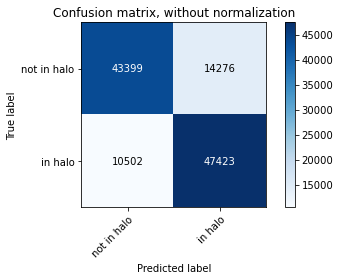

In [49]:
plot_confusion_matrix(y_test, ypred.round(), classes=['not in halo', 'in halo'])

Confusion matrix, without normalization
[[43713 13962]
 [10624 47301]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

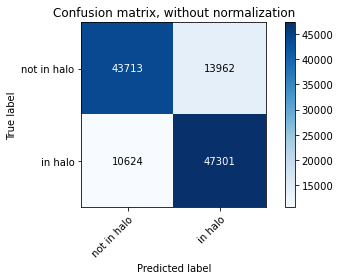

In [50]:
plot_confusion_matrix(y_test, ypred2.round(), classes=['not in halo', 'in halo'])